In [1]:
# install pyspark

!pip install pyspark

In [2]:
# configurating spark session

#importing Apache Spark entry points and Spark SQL Context
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

#create or retrieve the spark session 
spark = SparkSession.builder.appName("ProblemSpecification").getOrCreate()
sc = spark.sparkContext

# creating an instance of SQLContext
sqlContext = SQLContext(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/13 17:58:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
# importing additional libraries
from pyspark.sql.functions import col, sum, when, min
import pandas as pd

In [4]:
# **************************** Part A (Data Exploration, Visualisation and Analytics) ***********************************************************

# **************************** Task 1: Loading and Preprocessing the Dataset ***********************************************************

# using the * wildcard to read all files ending in .csv. 
df_crime = spark.read.csv("/kaggle/input/crimedataset/*.csv", header = True, inferSchema = True)

# displaying current schema and column names in its raw state
df_crime.printSchema()

print("The number of records in the crimedataset:", df_crime.count())

root
 |-- Crime ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



The number of records in the crimedataset: 695700


In [5]:
# displaying the raw state of the dataframe after loading
df_crime.show()

+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+-----------------+--------------------+---------------------+-------+
|            Crime ID|              Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|        LSOA name|          Crime type|Last outcome category|Context|
+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+-----------------+--------------------+---------------------+-------+
|58047a3a95167140d...|2023-05-01 00:00:00|Nottinghamshire P...|Nottinghamshire P...|-1.347639|53.061766|On or near Regent...|E01019444|Amber Valley 003B|Violence and sexu...| Court result unav...|   NULL|
|8ac857a6be54f5424...|2023-05-01 00:00:00|Nottinghamshire P...|Nottinghamshire P...|-1.329102|53.024519|On or near Minkle...|E01019451|Amber Valley 012D|               Drugs| Unabl

In [6]:
# tidying coloumn names for easier referencing
df_crime = df_crime.withColumnRenamed("Crime ID", "Crime_ID")
df_crime = df_crime.withColumnRenamed("Reported by", "Reported_by")
df_crime = df_crime.withColumnRenamed("Falls within", "Falls_within")
df_crime = df_crime.withColumnRenamed("LSOA code", "LSOA_code")
df_crime = df_crime.withColumnRenamed("LSOA name", "LSOA_name")
df_crime = df_crime.withColumnRenamed("Crime type", "Crime_type")
df_crime = df_crime.withColumnRenamed("Last outcome category", "Last_outcome_category")

In [7]:
# checking the number of NULL Attributes for each column in original dataset
df_crime.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_crime.columns]).show() 

+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+
|Crime_ID|Month|Reported_by|Falls_within|Longitude|Latitude|Location|LSOA_code|LSOA_name|Crime_type|Last_outcome_category|Context|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+
|  110275|    0|          0|           0|     8746|    8746|       0|     8746|     8746|         0|               110275| 695700|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+-------+



In [8]:
# dropping the "Context" column as each row in this column includes a NULL value
df_crime = df_crime.drop("Context")

In [9]:
# fill null attributes
df_crime = df_crime.na.fill({"Crime_ID":"Unknown", "LSOA_code":"Unknown", "LSOA_name":"Unknown", "Last_outcome_category":"Unknown"})

In [10]:
# standardising county names and adding column
df_crime = df_crime.withColumn("County", 
                                 when(col("Reported_by") == "Derbyshire Constabulary", "Derbyshire")
                                 .when(col("Reported_by") == "Leicestershire Police", "Leicestershire")
                                 .when (col("Reported_by") == "Nottinghamshire Police", "Nottinghamshire")
                                )

In [11]:
df_crime.show()

+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+-----------------+--------------------+---------------------+---------------+
|            Crime_ID|              Month|         Reported_by|        Falls_within|Longitude| Latitude|            Location|LSOA_code|        LSOA_name|          Crime_type|Last_outcome_category|         County|
+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+-----------------+--------------------+---------------------+---------------+
|58047a3a95167140d...|2023-05-01 00:00:00|Nottinghamshire P...|Nottinghamshire P...|-1.347639|53.061766|On or near Regent...|E01019444|Amber Valley 003B|Violence and sexu...| Court result unav...|Nottinghamshire|
|8ac857a6be54f5424...|2023-05-01 00:00:00|Nottinghamshire P...|Nottinghamshire P...|-1.329102|53.024519|On or near Minkle...|E01019451|Amber Valley 

In [12]:
# **************************** Task 2: Descriptive Data Analytics using Spark SQL ***********************************************************

# Create SQL Temporary View
df_crime.createOrReplaceTempView("CrimeData")

In [13]:
# SQL Query to calculate total no. of crimes reported in each county for 2023 and 2024
crimes_per_county = spark.sql("""
    SELECT County, substring(Month, 1, 4) AS Year, Count (*) as Total_crimes_reported
    From CrimeData
    GROUP BY County, Year
""")

crimes_per_county.show()

+---------------+----+---------------------+
|         County|Year|Total_crimes_reported|
+---------------+----+---------------------+
|Nottinghamshire|2023|               134619|
|Nottinghamshire|2024|               123798|
|     Derbyshire|2023|               114103|
|     Derbyshire|2024|               105236|
| Leicestershire|2024|               107902|
| Leicestershire|2023|               110042|
+---------------+----+---------------------+



In [14]:
# SQL Query to calculate the total number of crimes per year and month for each county
crimes_per_year_month = spark.sql("""
    SELECT County, substring(Month, 1, 7) AS Date, COUNT(*) AS Total_crimes
    FROM CrimeData
    GROUP BY County, Date
    ORDER BY Total_crimes DESC
""")

crimes_per_year_month.show()

+---------------+-------+------------+
|         County|   Date|Total_crimes|
+---------------+-------+------------+
|Nottinghamshire|2023-05|       12471|
|Nottinghamshire|2023-06|       12346|
|Nottinghamshire|2023-07|       11876|
|Nottinghamshire|2023-04|       11737|
|Nottinghamshire|2024-07|       11731|
|Nottinghamshire|2023-03|       11640|
|Nottinghamshire|2024-05|       11552|
|Nottinghamshire|2023-08|       11445|
|Nottinghamshire|2023-09|       11277|
|Nottinghamshire|2023-10|       11095|
|Nottinghamshire|2024-08|       10929|
|Nottinghamshire|2023-02|       10889|
|     Derbyshire|2023-05|       10744|
|Nottinghamshire|2023-01|       10665|
|Nottinghamshire|2024-06|       10647|
|Nottinghamshire|2024-03|       10476|
|     Derbyshire|2023-06|       10423|
|Nottinghamshire|2024-10|       10393|
|     Derbyshire|2023-07|       10152|
|     Derbyshire|2023-04|       10151|
+---------------+-------+------------+
only showing top 20 rows



In [15]:
# SQL Query to calculate most common and least common crime types in each county

# Query used to rank crime types by frequency only
spark.sql("""
    SELECT County, Crime_type, COUNT (Crime_type) AS Crime_count
    FROM CrimeData
    GROUP BY County, Crime_type
    ORDER BY County, Crime_count DESC
""").show(42, truncate = False)

+---------------+----------------------------+-----------+
|County         |Crime_type                  |Crime_count|
+---------------+----------------------------+-----------+
|Derbyshire     |Violence and sexual offences|85816      |
|Derbyshire     |Anti-social behaviour       |35537      |
|Derbyshire     |Public order                |21519      |
|Derbyshire     |Criminal damage and arson   |16416      |
|Derbyshire     |Other theft                 |14375      |
|Derbyshire     |Shoplifting                 |13826      |
|Derbyshire     |Vehicle crime               |8795       |
|Derbyshire     |Burglary                    |7541       |
|Derbyshire     |Drugs                       |5411       |
|Derbyshire     |Other crime                 |4335       |
|Derbyshire     |Possession of weapons       |2010       |
|Derbyshire     |Robbery                     |1341       |
|Derbyshire     |Theft from the person       |1265       |
|Derbyshire     |Bicycle theft               |1152      

In [16]:
# Query used to filter through the ranking and provide only most and least frequent

spark.sql("""
    SELECT c.County, c.Crime_type, c.Crime_count
FROM (
    SELECT County, Crime_type, COUNT(Crime_type) AS Crime_count
    FROM CrimeData
    GROUP BY County, Crime_type
) c
JOIN (
    SELECT County, MAX(Crime_count) AS Max_count, MIN(Crime_count) AS Min_count
    FROM (
        SELECT County, Crime_type, COUNT(Crime_type) AS Crime_count
        FROM CrimeData
        GROUP BY County, Crime_type
    ) 
    GROUP BY County
) min_max
ON c.County = min_max.County
WHERE c.Crime_count = min_max.Max_count OR c.Crime_count = min_max.Min_count
ORDER BY c.County, c.Crime_count DESC
""").show(truncate = False)

+---------------+----------------------------+-----------+
|County         |Crime_type                  |Crime_count|
+---------------+----------------------------+-----------+
|Derbyshire     |Violence and sexual offences|85816      |
|Derbyshire     |Bicycle theft               |1152       |
|Leicestershire |Violence and sexual offences|81604      |
|Leicestershire |Robbery                     |1735       |
|Nottinghamshire|Violence and sexual offences|76255      |
|Nottinghamshire|Theft from the person       |1902       |
+---------------+----------------------------+-----------+



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

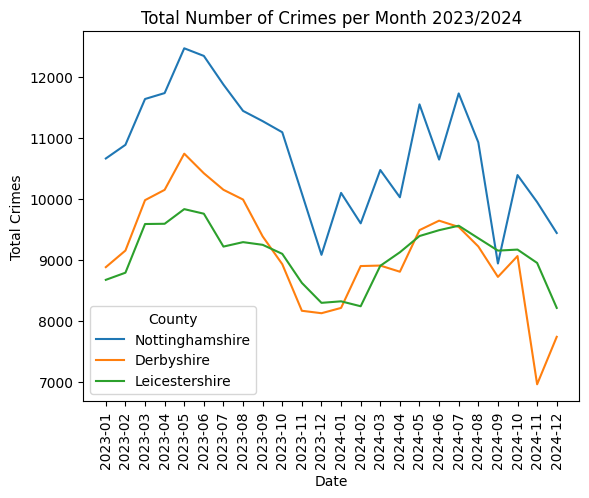

In [17]:
# **************************** Task 3: Data Visualisation ***********************************************************

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Line plot showing total no. of crimes per month and year for each county
crimes_per_year_month_pd = crimes_per_year_month.orderBy(crimes_per_year_month.Date, ascending = True).toPandas()

sns.lineplot(data = crimes_per_year_month_pd, x = "Date", y = "Total_crimes", hue = "County")

plt.title("Total Number of Crimes per Month 2023/2024")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Total Crimes")
plt.show()

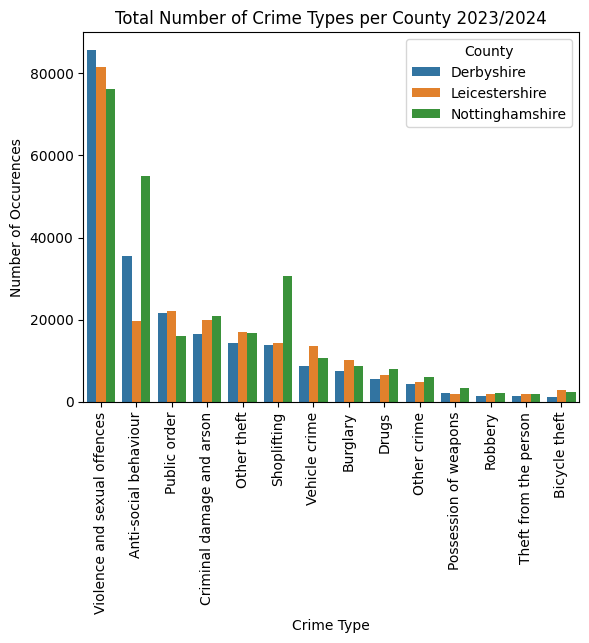

In [18]:
# Bar chart comparing total no. of each crime types for each county over the 24 months

crimetype_per_county = spark.sql("""
    SELECT County, Crime_type, COUNT (Crime_type) AS Crime_count
    FROM CrimeData
    GROUP BY County, Crime_type
    ORDER BY County, Crime_count DESC
""").toPandas()

sns.barplot(data = crimetype_per_county, x = "Crime_type", y = "Crime_count", hue = "County")
plt.xlabel("Crime Type")
plt.ylabel("Number of Occurences")
plt.title("Total Number of Crime Types per County 2023/2024")
plt.xticks(rotation = 90)

plt.show()



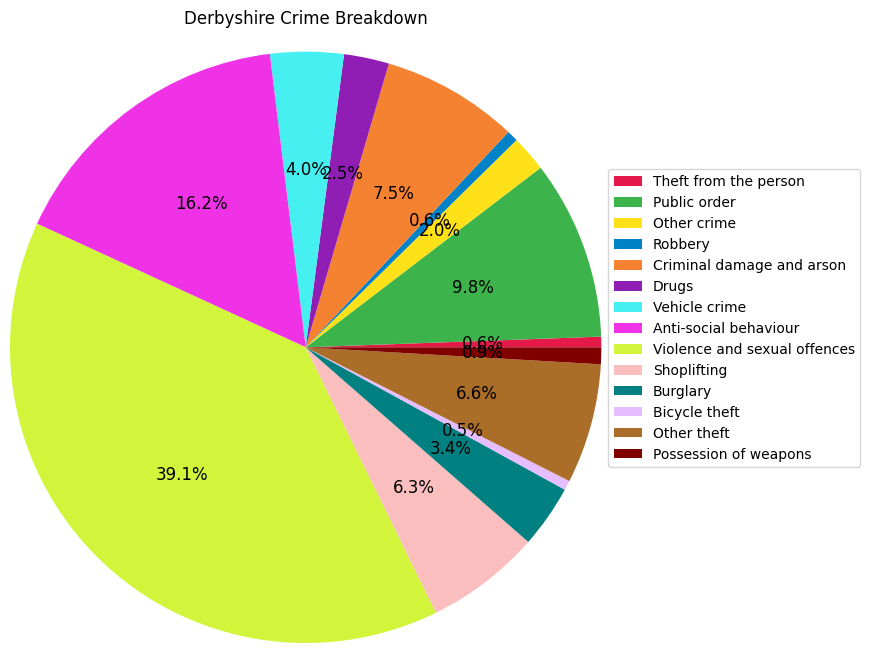

In [19]:
# 3 pie charts, one for each county, showing % breakdowns of crime types.

# Distinct color scheme for the charts - ensures clear visability on the legend
colors = ["#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231", "#911eb4", "#46f0f0", "#f032e6", "#d2f53c", "#fabebe", "#008080", "#e6beff", "#aa6e28", "#800000"]


# Pie chart for Derbyshire
derby_pie = spark.sql("""
    SELECT County, Crime_type, COUNT(Crime_type) AS Crime_count
    FROM CrimeData
    WHERE County = "Derbyshire"
    GROUP BY County, Crime_type
""").toPandas()

plt.pie(derby_pie["Crime_count"], colors = colors, labels = None, autopct = "%1.1f%%", textprops={"size": "larger"}, radius = 2.0)
plt.legend(derby_pie["Crime_type"], bbox_to_anchor=(1.3, 1))
plt.title("Derbyshire Crime Breakdown", pad = 100)
plt.show()



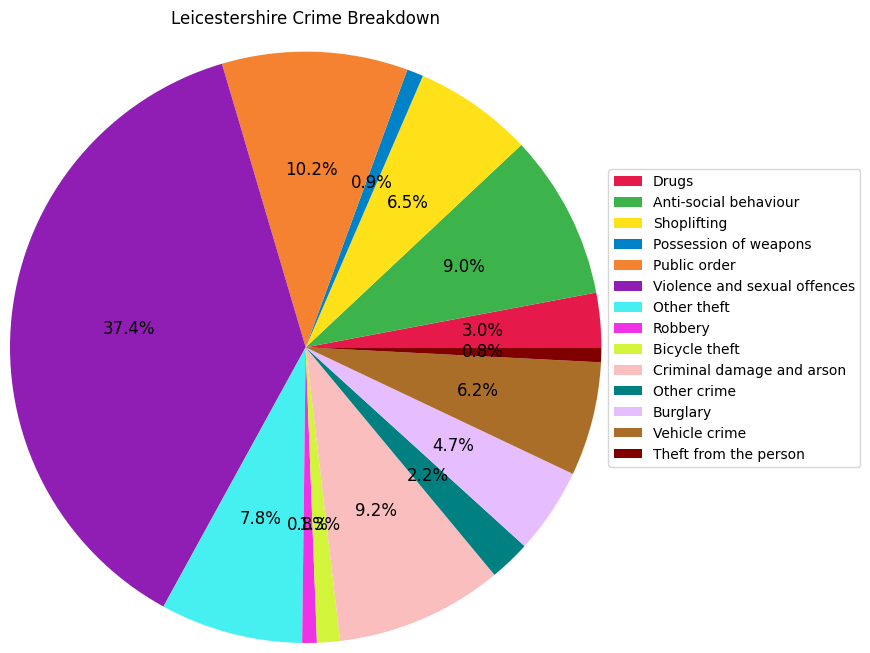

In [20]:
# Pie Chart for Leicestershire
leics_pie = spark.sql("""
    SELECT County, Crime_type, COUNT(Crime_type) AS Crime_count
    FROM CrimeData
    WHERE County = "Leicestershire"
    GROUP BY County, Crime_type
""").toPandas()

plt.pie(leics_pie["Crime_count"], colors = colors, labels = None, autopct = "%1.1f%%", textprops={"size": "larger"}, radius = 2.0)
plt.legend(leics_pie["Crime_type"], bbox_to_anchor=(1.3, 1))
plt.title("Leicestershire Crime Breakdown", pad = 100)
plt.show()


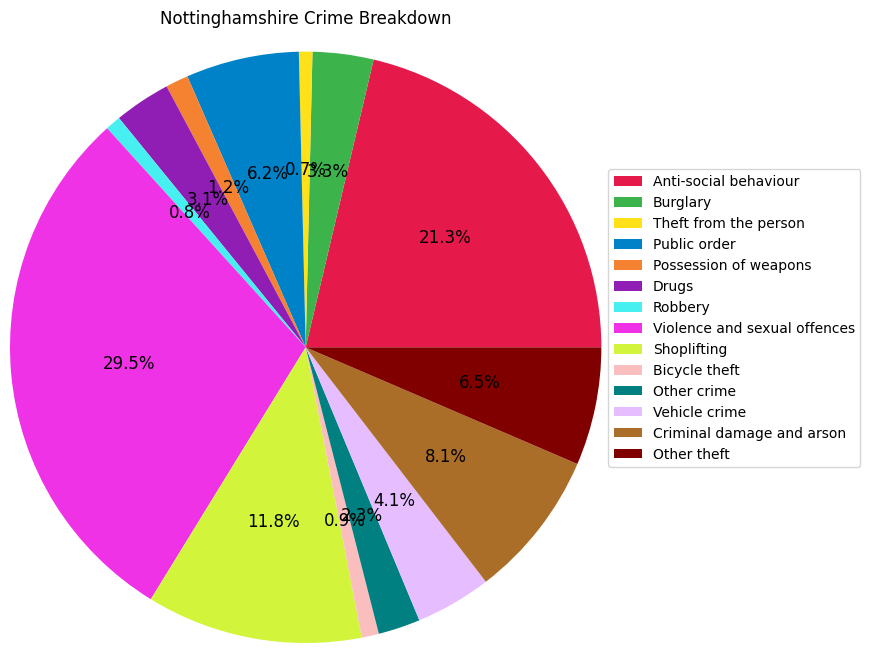

In [21]:
# Pie chart for Nottinghamshire
nottm_pie = spark.sql("""
    SELECT County, Crime_type, COUNT(Crime_type) AS Crime_count
    FROM CrimeData
    WHERE County = "Nottinghamshire"
    GROUP BY County, Crime_type
""").toPandas()

plt.pie(nottm_pie["Crime_count"], colors = colors, labels = None, autopct = "%1.1f%%", textprops={"size": "larger"}, radius = 2.0)
plt.legend(nottm_pie["Crime_type"], bbox_to_anchor=(1.3, 1))
plt.title("Nottinghamshire Crime Breakdown", pad = 100)
plt.show()



In [22]:
# **************************** Part B (Develop solutions to machine learning problems using MlLib) ***********************************************************

# Create DataFrame and read data, apply header, and infer schema
df_loan = spark.read.csv("/kaggle/input/loandataset/train_loan.csv", inferSchema = True, header = True)

In [23]:
df_loan.printSchema()
df_loan.show()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-------------

In [24]:
# check null attributes
df_loan.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_loan.columns]).show() 

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|      0|    13|      3|        15|        0|           32|              0|                0|        22|              14|            50|            0|          0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



In [25]:
# **************************** Task 1: Data Preprocessing ***********************************************************
import pyspark.sql.functions as F

# Handle Missing Values:

# finding the most common value in Loan_Amount_Term column
mode_loan_term = df_loan.agg(F.mode("Loan_Amount_Term")).collect()[0][0] # fill using most common in column

# finding the avg value in LoanAmount column
mean_loan_amount = df_loan.agg(F.mode("LoanAmount")).collect()[0][0] # fill using average in column


# filling the null records in the dataframe
df_loan = df_loan.na.fill({"Credit_History" : 0, "Loan_Amount_Term" : mode_loan_term, "LoanAmount" : mean_loan_amount,
                           "Dependents" : "0", "Married" : "Unknown" , "Self_Employed" : "Unknown", "Gender" : "Unknown"})


In [26]:
# Loan_ID not needed for prediction model evaluation
df_loan = df_loan.drop("Loan_ID")

df_loan.show()
df_loan.printSchema()

+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|  Male|     No|         0|    Graduate|           No|           5849|              0.0|       120|             360|             1|        Urban|          Y|
|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y|
|  Male|    Yes|         0|Not Graduate|           N

In [27]:
# show an updated count of nulls per column
df_loan.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_loan.columns]).show() 

+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|     0|      0|         0|        0|            0|              0|                0|         0|               0|             0|            0|          0|
+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



In [28]:
from pyspark.ml.feature import StringIndexer

# create an instand of encoded df to prevent errors when re-running program
df_loan_encoded = df_loan

# Encoding Categorical Variables and Applying Transformations
gender_indexer = StringIndexer(inputCol = "Gender", outputCol = "Gender_encoded")
df_loan_encoded = gender_indexer.fit(df_loan_encoded).transform(df_loan_encoded)

married_indexer = StringIndexer(inputCol = "Married", outputCol = "Married_encoded")
df_loan_encoded = married_indexer.fit(df_loan_encoded).transform(df_loan_encoded)

dependents_indexer = StringIndexer(inputCol = "Dependents", outputCol = "Dependents_encoded")
df_loan_encoded = dependents_indexer.fit(df_loan_encoded).transform(df_loan_encoded)

education_indexer = StringIndexer(inputCol = "Education", outputCol = "Education_encoded")
df_loan_encoded = education_indexer.fit(df_loan_encoded).transform(df_loan_encoded)

self_employed_indexer = StringIndexer(inputCol = "Self_Employed", outputCol = "Self_Employed_encoded")
df_loan_encoded = self_employed_indexer.fit(df_loan_encoded).transform(df_loan_encoded)

property_area_indexer = StringIndexer(inputCol = "Property_Area", outputCol = "Property_Area_encoded")
df_loan_encoded = property_area_indexer.fit(df_loan_encoded).transform(df_loan_encoded)

label_indexer = StringIndexer(inputCol = "Loan_Status", outputCol = "label")
df_loan_encoded = label_indexer.fit(df_loan_encoded).transform(df_loan_encoded)

In [29]:
df_loan_encoded.printSchema()

# Showing the resulting encoded columns
df_loan_encoded.select(["Gender_encoded", "Married_encoded", "Dependents_encoded", "Education_encoded", "Self_Employed_encoded", "Property_Area_encoded", "label"]).show()

root
 |-- Gender: string (nullable = false)
 |-- Married: string (nullable = false)
 |-- Dependents: string (nullable = false)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = false)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = false)
 |-- Loan_Amount_Term: integer (nullable = false)
 |-- Credit_History: integer (nullable = false)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)
 |-- Gender_encoded: double (nullable = false)
 |-- Married_encoded: double (nullable = false)
 |-- Dependents_encoded: double (nullable = false)
 |-- Education_encoded: double (nullable = false)
 |-- Self_Employed_encoded: double (nullable = false)
 |-- Property_Area_encoded: double (nullable = false)
 |-- label: double (nullable = false)

+--------------+---------------+------------------+-----------------+---------------------+---------------------+---

In [30]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# drop column initially to prevent errors when re-running program
df_loan_encoded = df_loan_encoded.drop("features")

# Assembling features into a single vector column
assembler = VectorAssembler(inputCols = ["Gender_encoded", "Married_encoded", "Dependents_encoded", 
                                        "Education_encoded", "Self_Employed_encoded", "ApplicantIncome", 
                                        "CoapplicantIncome", "LoanAmount", "Credit_History", "Property_Area_encoded"], 
                           outputCol = "features")
# Apply transformation
df_loan_encoded = assembler.transform(df_loan_encoded)

In [31]:
from pyspark.ml.feature import MinMaxScaler

# Scaling features column
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaled_features")

scaled_df = scaler.fit(df_loan_encoded).transform(df_loan_encoded)

In [32]:
scaled_df.show(truncate = False)
scaled_df.printSchema()

+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+--------------+---------------+------------------+-----------------+---------------------+---------------------+-----+-------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|Gender|Married|Dependents|Education   |Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|Gender_encoded|Married_encoded|Dependents_encoded|Education_encoded|Self_Employed_encoded|Property_Area_encoded|label|features                                         |scaled_features                                                                                            |
+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-

In [33]:
# Select the label and scaled_features column for ML modelling
prepared_df = scaled_df.select("scaled_features", "label")

In [34]:
# Displaying the final dataset with scaled features and a target label to be used for training / testing
prepared_df.show(truncate = False)

+-----------------------------------------------------------------------------------------------------------+-----+
|scaled_features                                                                                            |label|
+-----------------------------------------------------------------------------------------------------------+-----+
|(10,[1,5,7,8,9],[0.5,0.07048855905998763,0.1606367583212735,1.0,0.5])                                      |0.0  |
|[0.0,0.0,0.3333333333333333,0.0,0.0,0.05482993197278912,0.03619171046631627,0.17221418234442834,1.0,1.0]   |1.0  |
|(10,[4,5,7,8,9],[0.5,0.0352504638218924,0.08248914616497828,1.0,0.5])                                      |0.0  |
|[0.0,0.0,0.0,1.0,0.0,0.030092764378478666,0.05659154726762186,0.1606367583212735,1.0,0.5]                  |0.0  |
|(10,[1,5,7,8,9],[0.5,0.07235621521335807,0.191027496382055,1.0,0.5])                                       |0.0  |
|[0.0,0.0,0.6666666666666666,0.0,0.5,0.06514533085961657,0.1007031943744

In [35]:
# Split the data (72% training, 28% testing)
train, test = prepared_df.randomSplit([0.72, 0.28], seed = 1234)

In [36]:
# **************************** Task 2: Apply Classification Algorithms Using MLlib ***********************************************************
# Chosen Classification Algorithms: Decision Tree, Naive Bayes and Logistic Regression

In [37]:
# Training a Decision Tree Classifier
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol = "label", featuresCol = "scaled_features")

# Train the DT model
dt_model = dt.fit(train)

In [38]:
# Test the model
dt_predictions = dt_model.transform(test)
dt_predictions.show()

+--------------------+-----+-------------+--------------------+----------+
|     scaled_features|label|rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+----------+
|(10,[0,1,4,5,7],[...|  1.0|  [18.0,47.0]|[0.27692307692307...|       1.0|
|(10,[0,1,5,7],[0....|  1.0|  [18.0,47.0]|[0.27692307692307...|       1.0|
|(10,[0,1,5,7,9],[...|  1.0|    [3.0,9.0]|         [0.25,0.75]|       1.0|
|(10,[0,1,5,7,9],[...|  1.0|  [18.0,47.0]|[0.27692307692307...|       1.0|
|(10,[0,1,5,8,9],[...|  1.0|  [96.0,30.0]|[0.76190476190476...|       0.0|
|(10,[0,2,5,6,7],[...|  0.0|  [18.0,47.0]|[0.27692307692307...|       1.0|
|(10,[0,2,5,6,7],[...|  1.0|  [18.0,47.0]|[0.27692307692307...|       1.0|
|(10,[0,3,5,6,7],[...|  1.0|  [18.0,47.0]|[0.27692307692307...|       1.0|
|(10,[0,3,5,7,9],[...|  0.0|  [18.0,47.0]|[0.27692307692307...|       1.0|
|(10,[0,4,5,6,7],[...|  0.0|   [0.0,11.0]|           [0.0,1.0]|       1.0|
|(10,[0,5,6,7,8],[...|  0

In [39]:
# Training a Logistic Regression Model
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol = "label", featuresCol = "scaled_features")

# Train the  LR model
lr_model = lr.fit(train)

In [40]:
# Test the model
lr_predictions = lr_model.transform(test)
lr_predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|     scaled_features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(10,[0,1,4,5,7],[...|  1.0|[-0.6661855330504...|[0.33935148923001...|       1.0|
|(10,[0,1,5,7],[0....|  1.0|[-0.5197850402550...|[0.37290249983828...|       1.0|
|(10,[0,1,5,7,9],[...|  1.0|[-0.8112947977208...|[0.30761465080551...|       1.0|
|(10,[0,1,5,7,9],[...|  1.0|[-0.9324884769032...|[0.28242012932313...|       1.0|
|(10,[0,1,5,8,9],[...|  1.0|[1.57212965776054...|[0.82808699591774...|       0.0|
|(10,[0,2,5,6,7],[...|  0.0|[0.05644148349531...|[0.51410662618534...|       0.0|
|(10,[0,2,5,6,7],[...|  1.0|[0.17395986187155...|[0.54338062178604...|       0.0|
|(10,[0,3,5,6,7],[...|  1.0|[-0.6639104199541...|[0.33986173778514...|       1.0|
|(10,[0,3,5,7,9],[...|  0.0|[-1.2511213266508...|[0.22250609217218...|       1.0|
|(10,[0,4,5,6,7]

In [41]:
# Training a Naive Bayes Model
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(labelCol = "label", featuresCol = "scaled_features")
nb_model = nb.fit(train)

In [42]:
# Test the model
nb_predictions = nb_model.transform(test)
nb_predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|     scaled_features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(10,[0,1,4,5,7],[...|  1.0|[-5.3127939936763...|[0.64500452211971...|       0.0|
|(10,[0,1,5,7],[0....|  1.0|[-3.5931912710214...|[0.66532341531696...|       0.0|
|(10,[0,1,5,7,9],[...|  1.0|[-4.4240458803847...|[0.62962732850921...|       0.0|
|(10,[0,1,5,7,9],[...|  1.0|[-4.7924918112176...|[0.62521090215677...|       0.0|
|(10,[0,1,5,8,9],[...|  1.0|[-5.1775823641222...|[0.74740436356391...|       0.0|
|(10,[0,2,5,6,7],[...|  0.0|[-4.2592565148316...|[0.69358552592344...|       0.0|
|(10,[0,2,5,6,7],[...|  1.0|[-5.6397047619584...|[0.70029287671228...|       0.0|
|(10,[0,3,5,6,7],[...|  1.0|[-5.4168311963116...|[0.58404679568130...|       0.0|
|(10,[0,3,5,7,9],[...|  0.0|[-6.7544559074837...|[0.51178332200075...|       0.0|
|(10,[0,4,5,6,7]

In [43]:
# **************************** Task 3: Model Evaluation and Comparison ***********************************************************

from pyspark.mllib.evaluation import MulticlassMetrics

# Extract predictions and labels
dt_preds_and_labels = dt_predictions.select("prediction", "label").rdd
lr_preds_and_labels = lr_predictions.select("prediction", "label").rdd
nb_preds_and_labels = nb_predictions.select("prediction", "label").rdd

# Evaluate using MultiClassMetrics
dt_metrics = MulticlassMetrics(dt_preds_and_labels)
lr_metrics = MulticlassMetrics(lr_preds_and_labels)
nb_metrics = MulticlassMetrics(nb_preds_and_labels)

# Calculating the accuracy for each model
dt_accuracy = dt_metrics.accuracy
lr_accuracy = lr_metrics.accuracy
nb_accuracy = nb_metrics.accuracy

# Calculating the precision for each model
dt_precision = dt_metrics.weightedPrecision
lr_precision = lr_metrics.weightedPrecision
nb_precision = nb_metrics.weightedPrecision

# Calculating the recall for each model
dt_recall = dt_metrics.weightedRecall
lr_recall = lr_metrics.weightedRecall
nb_recall = nb_metrics.weightedRecall 

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [44]:
# Displaying the results
print(f"Decision Tree - Accuracy: {dt_accuracy} Precision: {dt_precision}, Recall: {dt_recall}")
print(f"Logistic Regression - Accuracy: {lr_accuracy}, Precision: {lr_precision}, Recall: {lr_recall}")
print(f"Naive Bayes - Accuracy: {nb_accuracy}, Precision: {nb_precision}, Recall: {nb_recall}")

Decision Tree - Accuracy: 0.7454545454545455 Precision: 0.7344233884640018, Recall: 0.7454545454545455
Logistic Regression - Accuracy: 0.7454545454545455, Precision: 0.7349226435890109, Recall: 0.7454545454545455
Naive Bayes - Accuracy: 0.6848484848484848, Precision: 0.7853876185164528, Recall: 0.6848484848484848


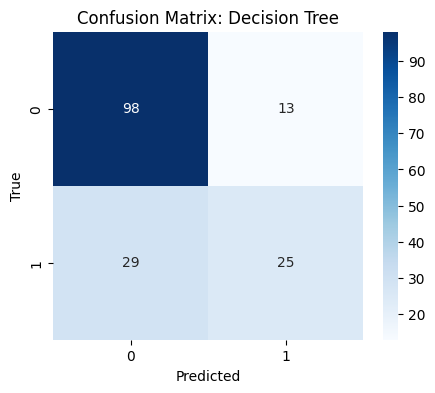

In [45]:
# Creating a Confusion Matrix for each model

# Get confusion matrix as numpy arrays
dt_confusion_matrix = dt_metrics.confusionMatrix().toArray()
lr_confusion_matrix = lr_metrics.confusionMatrix().toArray()
nb_confusion_matrix = nb_metrics.confusionMatrix().toArray()

# Plot heatmap for Decision Tree Classification 
plt.figure(figsize = (5, 4))
sns.heatmap(dt_confusion_matrix, annot = True, fmt = ".0f", cmap = "Blues")
plt.title("Confusion Matrix: Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

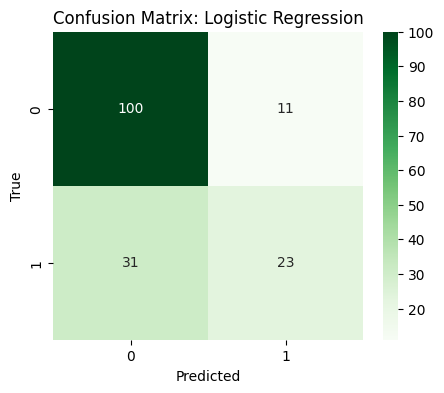

In [46]:
# Plot heatmap for Logistic Regression
plt.figure(figsize = (5, 4))
sns.heatmap(lr_confusion_matrix, annot = True, fmt = ".0f", cmap = "Greens")
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

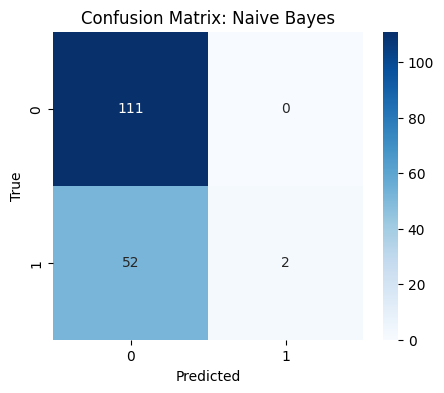

In [47]:
# Plot heatmap for Naive Bayes
plt.figure(figsize = (5, 4))
sns.heatmap(nb_confusion_matrix, annot = True, fmt = ".0f", cmap = "Blues")
plt.title("Confusion Matrix: Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()